# データセットとデータローダ

データサンプルを処理するコードは煩雑でメンテナンスが大変です。
理想的には、データセットのコードはモデルのトレーニングコードから切り離すことで、読みやすさとモジュール性を高めます。
PyTorchには2つのデータプリミティブがあります。それは `torch.utils.data.DataLoader` と `torch.utils.data.Dataset` です。
これらのプリミティブを使用することで、あらかじめロードされたデータセットや独自のデータを使用することができます。
`Dataset`にはサンプルとそれに対応するラベルが格納されており、`DataLoader`は`Dataset`にイテレート可能なデータをラップすることで、サンプルへのアクセスを容易にしています。

PyTorchドメインライブラリは、以下のような多くのプリロードされたデータセット(FashionMNISTなど)を提供しています。
このライブラリは、 `torch.utils.data.Dataset` をサブクラス化し、特定のデータに固有の関数を実装しています。
これらのライブラリは、モデルのプロトタイプやベンチマークに使用できます。これらは以下の通りです。
ここをクリックしてください。[Image Datasets](https://pytorch.org/vision/stable/datasets.html),
[Text Datasets](https://pytorch.org/text/stable/datasets.html), および
[Audio Datasets](https://pytorch.org/audio/stable/datasets.html)

## データセットのロード

TorchVisionから[Fashion-MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)データセットを読み込む例を紹介します。
Fashion-MNISTは、Zalandoの記事画像のデータセットで、60,000のトレーニング例と10,000のテスト例で構成されています。
各例は、28×28のグレースケール画像と、10のクラスのうちの1つの関連するラベルから構成されています。

[FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist)を以下のパラメータで読み込みます。

- `root` はトレーニング/テストデータが保存されているパスです。
- `train` はトレーニングデータセットまたはテストデータセットを指定します。
- `download=True` は、`root` にデータがない場合、インターネットからデータをダウンロードします。
- `transform`と`target_transform`は、特徴とラベルの変換を指定します。



In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


26422272it [02:45, 160022.24it/s]                              


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


29696it [00:00, 116641.56it/s]                          


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


4422656it [00:04, 988402.25it/s]                              


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


6144it [00:00, 10450042.08it/s]         

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!



/Users/shogo/miniforge3/envs/pytorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-4gogm3_o/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


データセットのイテレーションとビジュアル化
-----------------

`Datasets` をリストのように手動でインデックスすることができます。``training_data[index]`` 
ここでは， `matplotlib` を用いて，学習データの中のいくつかのサンプルを可視化します．


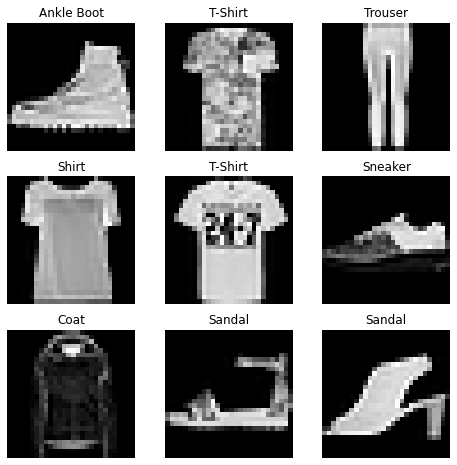

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


ファイルのカスタムデータセットの作成
---------------------------------------------------

カスタムデータセットクラスは、3つの関数を実装する必要があります。`__init__`, `__len__`, `__getitem__` です。
この実装を見てみましょう。FashionMNISTの画像は、`img_dir`に格納されています。
FashionMNISTの画像はディレクトリ `img_dir` に格納され、ラベルはCSVファイル `annotations_file` に別々に格納されています。

次のセクションでは、これらの各関数で何が起こっているかを説明します。



In [6]:
import os
import pandas as pd
import torchvision.io as tvio


class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = tvio.read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample


## init

`__init__` 関数は、Datasetオブジェクトをインスタンス化する際に一度だけ実行されます。初期化するのは
画像の入ったディレクトリ、アノテーションファイル、両方のトランスフォーム（次のセクションで詳しく説明します)。

labels.csvファイルは以下のようになります。

```python

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9
```

例:

```python
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
```


## len

関数 `__len__` は、データセットのサンプル数を返します。

例:

```python
def __len__(self):
    return len(self.img_labels)
```


## getitem

`__getitem__` 関数は、データセットから、与えられたインデックス `idx` にあるサンプルをロードして返します。
インデックスに基づき，画像のディスク上の位置を特定し，それを `read_image` でテンソルに変換し，対応するラベルを `self.img_labels` のcsvデータから取得する．
対応するラベルを `self.img_labels` のcsvデータから取得し，（必要に応じて）それらの変換関数を呼び出し，テンソル画像と対応するラベルを 
テンソルイメージと対応するラベルをPythonの`dict`で返します。

例:

```python
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1] (ラベル)
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}。
    return sample
```


DataLoadersによるトレーニング用データの準備
-------------------------------------------------
`Dataset`は、データセットの特徴量とラベルを1サンプルずつ取得します。
モデルを学習する際には，通常，サンプルを "ミニバッチ"で渡し，モデルのオーバーフィッティングを減らすためにエポック毎にデータを再編成し，Pythonの `multiprocessing` を使ってデータの取得を高速化したいと考えます．

`DataLoader` はイテレート可能で、この複雑さを簡単なAPIで抽象化してくれます。


In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## DataLoaderを反復処理する

データセットを `Dataloader` にロードしたので、必要に応じてデータセットを反復処理することができます。
以下の各イテレーションは，`train_features`と`train_labels`（それぞれ`batch_size=64`のフィーチャーとラベルを含む）のバッチを返します．`shuffle=True`を指定しているので，すべてのバッチを繰り返し処理した後に，データがシャッフルされます（データのロード順をより細かく制御するには，[例](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler>)を参照してください）．



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


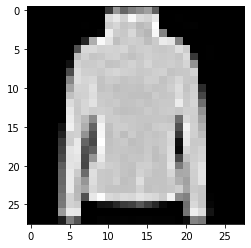

Label: 4


In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


# 知識の確認

1. PyTorch DataSetとPyTorch DataLoaderの違いは何ですか？

- DataSetはデータのバッチを扱うように設計されているのに対し、DataLoaderは個々のデータアイテムを検索するように設計されています。
  > DataSetは個々のデータアイテムを取得するために設計されており、DataLoaderはデータのバッチを扱うために設計されています。

- DataSetは個々のデータ項目を検索するように設計されていますが、DataLoaderはデータのバッチを扱うように設計されています。
  > 正解です。DataSetは個々のデータアイテムを取得するために設計されており、DataLoaderはデータのバッチを扱うために設計されています。

- DataLoaderクラスはDataSetクラスの親です。
  > DataSetは個々のデータアイテムを取得するために設計されており、DataLoaderはデータのバッチを扱うために設計されています。

- DataSetクラスは、DataLoaderクラスの親です。
  > DataSetは個々のデータアイテムを取得するために設計されており、DataLoaderはデータのバッチを扱うために設計されています。
